# Project 2 report - Analysis of tipping behaviour in NYC taxis
Github link: https://github.com/pp-22/pp-project-2-group-9-1

**Introduction**

Throughout this report we will be studying the tips received by the taxi drivers in New York City. In particular, we are going to focus in the traditional yellow taxis, and the scope of our study will be the summer months, from June to August. Our objective is to deduce some of the effects that explain the different tipping behaviours of the passengers.

**Data**

We are going to use the quarterly data (June, July and August) of yellow taxis in New York City in the year 2022 to analyse the tipping behavior during the summer months. Our main focus is to study the relation between the tips received by the taxi drivers and other parameters that are dependent on each individual taxi ride, such as the total trip distance, the total amount paid for the taxi ride, the duration of the trip, the weather (precipitation) at the time of the ride, the day of the week, whether the ride took place during the night hours of the day, and the stock market prices. After studying all these features, we model a linear regression that will attempt to predict the final tip of a taxi ride.

The data is first being cleaned, and we classify some data according to their attributes to see different tipping effects under each attribute. We also add weather data to see how weather will influence tips. 

**Structure**

The report is organized in the following way. Firstly, we obtain the required data, including the information of yellow taxi rides during the summer, the weather state during each hour from June to August, and the S&P500 stock market prices during these months.

Then, we will perform some data cleaning and engineering to have the data in the form needed for our exploratory data analysis.

Next, in the exploratory data analysis section, we are going to produce visualizations of how tips are affected by the variables for which we have information. 

Lastly, we will perform a linear regression, illustrating what factors affect more or less the received tips, and conclude with some recommendations for taxi drivers.

# Import libraries

In [1]:
#import all necessary library

import pandas as pd
import statsmodels.api as sm
from utils import get_taxi_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import time
import requests
from dateutil.parser import parse
import datetime
from matplotlib.pyplot import MultipleLocator
import geopandas as gpd
import matplotlib.colors as colors
import contextily as ctx
import io
import warnings
warnings.filterwarnings('ignore')

![separator1](https://i.imgur.com/ZUWYTii.png)

# Get the raw data


### Yellow Taxi Data

First, we download the required yellow taxi data for the year 2022 and the months June, July and August.

In [2]:
## Get data from yellow taxis in 2022 - June, July, August 

cols_to_read = ['tpep_pickup_datetime', 'tpep_dropoff_datetime','trip_distance', 'PULocationID', 
                'DOLocationID','total_amount','tip_amount'] #Make a list of the columns we want to import from the 
                                                            #dataset

yellow06 = get_taxi_data('2022', '06', 'yellow', columns=cols_to_read) #import the dataset from June
yellow07 = get_taxi_data('2022', '07', 'yellow', columns=cols_to_read) #import the dataset from July
yellow08 = get_taxi_data('2022', '08', 'yellow', columns=cols_to_read) #import the dataset from August

File not in current folder; trying to download data...
File not in current folder; trying to download data...
File not in current folder; trying to download data...


In [3]:
yellow = pd.concat([yellow06, yellow07, yellow08], ignore_index = True) #Join 3-month data together as a single
                                                                        #dataframe called yellow


---
###  Weather Data

Now, we define a function to obtain the hourly data of the weather forecast. We will use the freely available data from the open meteo API.

In [4]:
def get_weather_data(r, frequency, variables):
    '''
    This function returns a dictionary containing certain information from a JSON request. In particular, the keys of
    the dictionary are the features specified in the input.

    Inputs:
        r (Request): The request object.
        frequency (str): 'hourly' or 'daily'.
        variables (list): A list of the required variable names.

    Outputs:
            weather_dict (dict): a dictionary containing only the required data.
    '''
    
    data = r.json() # Parse the JSON data to a dictionary

    weather_dict = {'timestamps': [parse(t) for t in data[frequency]['time']]} # Start an empty dictionary, 
            #populate the timestamps parsed as datetime objects

    weather_dict['units'] = {var: data[f'{frequency}_units'][var] for var in variables} # Start a dictionary item
            #to store the units
    
    for var in variables: #For each required feature...
        weather_dict[var] = data[frequency][var] #...extract data and add information to dictionary

    return weather_dict # Return the dictionary with the required data


In [5]:
r = requests.get('https://archive-api.open-meteo.com/v1/era5?latitude=40.71&longitude=-74.01&start_date=2022-06-01&end_date=2022-08-31&hourly=temperature_2m,precipitation&timezone=America%2FNew_York')
    #request weather data from the above link
weather_dict = get_weather_data(r, "hourly", ['precipitation', 'temperature_2m']) #obtain dictionary with
                                                                                  #weather information


In [6]:
weather_dict.pop('units', None) #remove 'units' from the dictionary
weather = pd.DataFrame.from_dict(weather_dict) #transform dictionary to dataframe

---
### Stock Market Data (S&P 500 daily)

Lastly, we download that of the stock market prices during the summer months. The URL specified above belongs to 
our GitHub, which contains the required .csv file.

In [7]:
# This block of code is an adaption of the following:
# Author: Thomas Le Menestrel
# URL:https://medium.com/towards-entrepreneurship/importing-a-csv-file-from-github-in-a-jupyter-notebook-e2c28e7e74a5
# Accessed: 04/12/2022


url = "https://raw.githubusercontent.com/pruizbarnada/SP500/main/S%26P500.csv" #Access our public GitHub repo 
                                                                               #with the CSV file
download = requests.get(url).content #request the csv file

df = pd.read_csv(io.StringIO(download.decode('utf-8'))) #Read the csv file and transform it to a pandas dataframe

df = df.drop(['Unnamed: 2', 'NA'], axis=1) #remove the columns from the dataframe we don't need




![separator1](https://i.imgur.com/ZUWYTii.png)

# Data cleaning

In this section we will perform some data cleaning to remove outliers and some infeasible data (negative prices, negative distances, ...). In order to remove outliers about the duration of the trip (in time), we firstly produce a new column in the dataframe that simply substracts the time of the pickuo to the dropoff.

In general, we remove outliers by calculating expreme percentiles (1 and 99 percentiles) and the observations that lie outside those intervals are removed. We calculate the percentiles with respect to more than one of our numeric columns since we understand that outliers are generally wroongly recorded data, and this incorrect data is recorded independently between features within the same taxi ride.

As there are no null values in our dataset, we do not need to worry about them.

In [8]:
def trip_duration(df):
    '''
    This function calculates the duration of the taxi rides. In order to do this, it checks whether the dataframe 
    contains information about the pickup and dropoff times. If so, it calculates the difference between both timestamps
    in minutes, and returns the original dataframe with a new column, "duration_of_trip", containing the calculated times.
    Inputs:
        df (dataframe): Should contain columns "tpep_pickup_datetime" and "tpep_dropoff_datetime", with elements of type
            Timestamp.

    Outputs:
        df (dataframe): The original dataframe, with a new column containing the duration of the taxi rides, as floating
            points representing minutes.
    '''

    if (('tpep_dropoff_datetime' in df.columns) & ('tpep_pickup_datetime' in df.columns)): #if dataframe has 
                                                                        #information of pickup and dropoff times...
        df["duration_of_trip"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"] #calculate the difference
                        #between dropoff and pickup times, and store this value in a new column "duration_of_trip"
        
    df["duration_of_trip"] = df['duration_of_trip'] / np.timedelta64(1, 'm') #transform the elements of 
                        #"duration_of_trip" to floating points representing minutes.
    
    return df #return dataframe


In [9]:
def clean_data(df, prc_low = 1, prc_high = 99):
    '''
    This function takes a dataframe and removes outliers, duplicates and wrongly recorded data. To remove outliers, 
    it calculates high and low percentiles, established when the function is called, for certain numeric features. The
    observations that have a value lower than the lower-calculated percentile, or higher than the higher-calculated 
    percentile, are removed. The function returns the original dataframe after removing  outliers, duplicates and wrongly
    recorded data.

    Inputs:
        df (dataframe): Contains information of yellow taxis' rides.
        prc_low: Lower percentile to be calculated, set to 1 by default.
        prc_high: Higher percentile to be calculated, set to 99 by default.

    Outputs:
        df (dataframe): Contains information of yellow taxis' rides, without outliers, duplicates or wrongle recorded data.
    '''        

    df = df.drop_duplicates() #Drop duplicated observations
    
    #Drop observations that are wrong...
    df = df.drop(df[(df['total_amount'] <= 0)].index)  #Infeaseble total amount (less than or equal to 0)
    df = df.drop(df[(df['trip_distance'] <= 0)].index) #Infeaseble trip distance (less than or equal to 0)
    df = df.drop(df[(df['duration_of_trip'] <= 0)].index) #Infeaseble duration (less than or equal to 0)
    df = df.drop(df[(df['tpep_pickup_datetime'] < '2022-06-01')].index) #Pickup date before June
    df = df.drop(df[(df['tpep_pickup_datetime'] > '2022-09-01')].index) #Pickup date after August
    df = df.drop(df[(df['tip_amount'] < 0)].index) #Infeasible tip (less than 0)

    #Calculate percentiles for certain features
    price_prc_low = np.percentile(df['total_amount'], prc_low) # 1 percentile for total amount
    price_prc_high = np.percentile(df['total_amount'], prc_high) # 99 percentile for total amount
    distance_prc_low = np.percentile(df['trip_distance'], prc_low) # 1 percentile for trip distance
    distance_prc_high = np.percentile(df['trip_distance'], prc_high) # 99 percentile for trip distance
    duration_prc_low = np.percentile(df['duration_of_trip'], prc_low) # 1 percentile for trip duration
    duration_prc_high = np.percentile(df['duration_of_trip'], prc_high) # 99 percentile for trip duration
    tip_prc_high = np.percentile(df['tip_amount'], prc_high) # 99 percentile for tip amount
    
    #Drop outliers for any of the columns to be analysed if...    
    df = df.drop(df[(df['total_amount'] < price_prc_low)].index) #lower total amount than 1 percentile
    df = df.drop(df[(df['total_amount'] > price_prc_high)].index) #higher total amount than 99 percentile
    df = df.drop(df[(df['trip_distance'] < distance_prc_low)].index) #lower trip distance than 1 percentile
    df = df.drop(df[(df['trip_distance'] > distance_prc_high)].index) #higher trip distance than 99 percentile    
    df = df.drop(df[(df['duration_of_trip'] < duration_prc_low)].index) #shorter duration than 1 percentile
    df = df.drop(df[(df['duration_of_trip'] > duration_prc_high)].index) #longer duration than 99 percentile
    df = df.drop(df[(df['tip_amount'] > tip_prc_high)].index) #higher tip than 99 percentile
    
    return df #return dataframe

In [10]:
yellow = trip_duration(yellow) #calculate the duration of the taxi rides and add it to our main dataframe

In [11]:
yellow = clean_data(yellow) # call the function to clean the data and remove the outliers

In [12]:
#Sort the dataframe by ascending 'tpep_pickup_datetime' values
yellow = yellow.sort_values(by=['tpep_pickup_datetime']) 

---

# Data engineering

In this section we will join the information of our three data sets (yellow taxis, weather and S&P 500) and create some new variables from the information that is already contained in the data set. We will also transform some of the variables we have in order to be able to use them in the final regression.

**Generate information of days, times**

First, we isolate the pickup dates and times from each other. This allows us to obtain the days of the week in which each ride happened, know whether they happened during the week or the weekend, and define whether these rides were during night time (which we have defined to be from midnight to 6am) or during daytime.

In the last cell of this subsection, we produce dummy variables for each day of the week, which we might use in the final regression model we produce.

In [13]:
yellow['time'] = yellow['tpep_pickup_datetime'].dt.strftime("%H:%M:%S") #Create new colummn with the time of the taxi ride

yellow['date'] = yellow['tpep_pickup_datetime'].dt.date #Create new column with the date of the taxi ride

yellow['day'] = yellow['tpep_pickup_datetime'].dt.day_name() #Create new column with the day-name of the taxi ride

yellow['weekend'] = yellow['day'].isin(['Saturday', 'Sunday']) #Create new column with True values if the taxi ride
                                                               #was on the weekend, False otherwise
yellow.loc[(yellow['weekend'] == False), 'weekend'] = 0 #Transform False values to 0
yellow.loc[(yellow['weekend'] == True), 'weekend'] = 1 #Transform True values to 1

yellow['weekend'] = yellow['weekend'].astype(str).astype(int) #change type of elements of weekend to int 

In [14]:
timess = [datetime.datetime.strptime(times, '%H:%M:%S').time() for times in yellow['time']] #make a list with the 
    #values of the 'time' column (strings) as time objects

yellow['time_as_datetime'] = timess #Create new column containing the times of the taxi rides as time objects

yellow['night'] = 0 #create new column 'night', initialize the values to 0

In [15]:
night_start = time(0,0,0) #Define starting time
night_finish = time(6,0,0) #Define finishing time

yellow.loc[((yellow['time_as_datetime'] >= night_start) &
                     (yellow['time_as_datetime'] < night_finish)), 'night'] = 1
    #If the time of the taxi ride lies between the starting and finishing defined times, update the value of the 
    #column 'night' to 1


In [16]:
day_dums = pd.get_dummies(yellow['day']) #Obtain dummy variables for eacah day of the week (as a dataframe)
yellow = pd.concat((yellow, day_dums), axis = 1) #Concatenate the matrix with the dummy variables to the main dataframe

**Add hourly weather data**

Now, we will join the yellow taxi dataset with the weather dataset. As the weather data is given hourly, the taxi ride will have the associated weather of the (rounded) hour in which the ride started: for instance, if the taxi was taken at 13:17, the precipitation associated to it will be the one recoreded at 13:00. Therefore, all the taxis taken between 13:00 and 13:59 will have the same associated precipitation.

In [17]:
weather['date'] = weather['timestamps'].dt.date #create new column with the date of the weather observation
weather['time'] = weather['timestamps'].dt.strftime("%H:%M:%S") #create new column with the time
    #of the weather observation

In [18]:
start_date = np.datetime64("2022-06-01 00:00:00") #define starting date
end_date = np.datetime64("2022-09-01 00:00:00") #define finishing date
interval = np.timedelta64(1, "h") #define time interval

dates =  np.arange(start_date, end_date, interval) #generate a list of datetime64[s] objects, evenly
    #spaced by one hour, from start_date to end_date

for day_hour in dates: #For each datetime64[s] object in 'dates'...
    day_hour = pd.Timestamp(day_hour) #... transform element to Timestamp
    precip = weather.loc[(weather['timestamps']) == day_hour, 'precipitation'] #get the precipitation information
        #corresponding to that specific day and time
 
    yellow.loc[((yellow['tpep_pickup_datetime'] >= day_hour) &
                     (yellow['tpep_pickup_datetime'] < (day_hour + interval))), 'precipitation'] = precip.values[0]
        #Add the precipitation value to those taxi rides which began during the 1-hour interval of the specific
        #day and time

In [19]:
yellow['precip_yn'] = 0 #create new column accounting for the existence of precipitation (as a binary variable).
    #Initialise the values to be 0
yellow.loc[(yellow['precipitation'] > 0), 'precip_yn'] = 1 #If the recorded precipitation during the taxi ride is
    #positive, then set the value of the binary variable to 1.

**Add S&P 500 data**

Lastly, we add to our main dataframe the daily information of the S&P 500 price data. Even if apparently unrelated, we understand that the people that most often take taxis can be possibly associated with medium class, people that possibly have some small investments in the stock market. In the case that their stocks had gone up, they might feel really positive, and give larger tips to their taxi drivers.

In [20]:
datess = [datetime.datetime.strptime(date, '%Y/%m/%d').date() for date in df['date']] #make a list with the 
                                                            #unique days in the S&P 500 dataframe as a date object.
df['date'] = datess #add the dates as date objects to the S&P500 dataframe.

In [21]:
for date in datess: #For each datetime.date object in 'datess' (the unique dates for the S&P500 dataframe)...
    price = df.loc[(df['date']) == date, 'price'] #get the precipitation information
        #corresponding to that specific day and time
 
    yellow.loc[(yellow['date'] == date), 'SP500'] = price.values[0]
        #Add the precipitation value to those taxi rides which began during the 1-hour interval of the specific
        #day and time


![separator1](https://i.imgur.com/ZUWYTii.png)

## Exploratory Data Analysis

Now that we have prepared our data, we will start with the exploratory data analysis. In this section we will graphically analyse the features of our dataframe, with the objective of summarizing the main characteristics of the dataset and obtaining a deeper insight of the relations between our variables.

### Correlation

In this section we study the relation within the features in our dataset, with the objective of establishing relationships between the variables and thus make a sensible choice when performing the linear regression to predict tips, in the coming sections.

Firstly, we analyse the correlation between the continuous, numeric variables for which we have information - tip amount, trip distance, duration of trip, total amount paid and precipitation. Then, we consider the dummy variables we have generated in the previous section and see how they are related to these continuous numeric variables. Lastly, we consider the correlation with the S&P 500 prices.

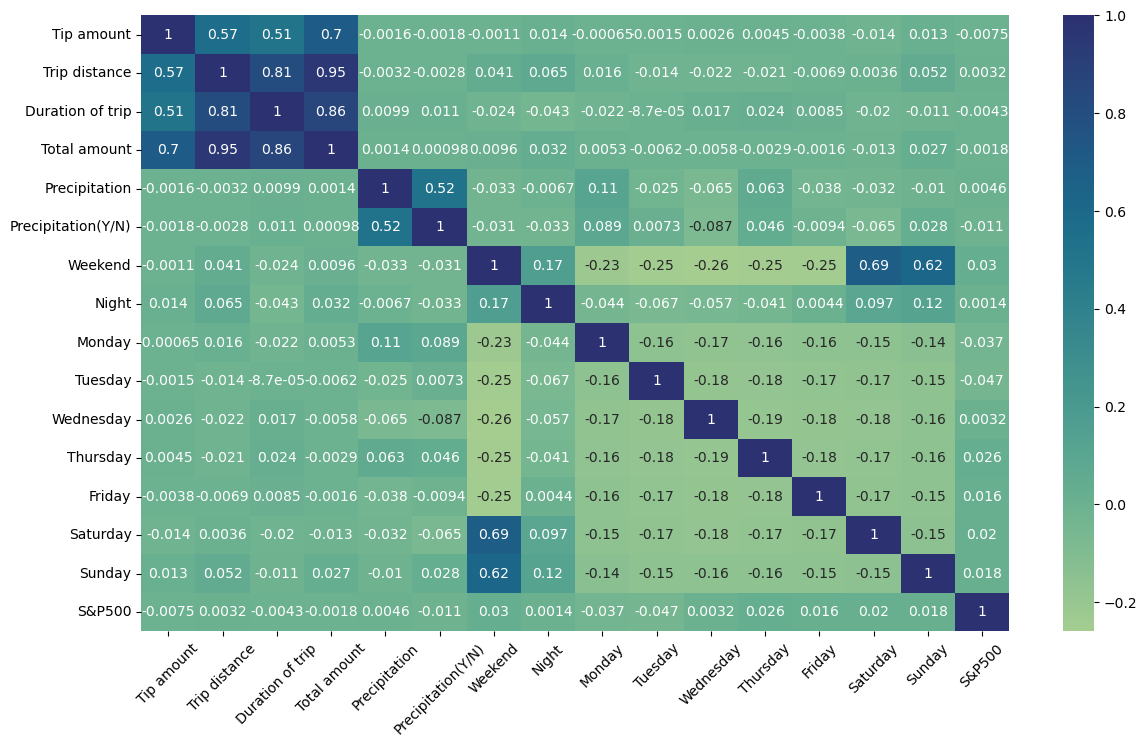

In [25]:
corr_vars = ["tip_amount", "trip_distance" , "duration_of_trip", "total_amount", 'precipitation', 'precip_yn',
             'weekend', 'night', 'Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'SP500']
        #set the variables to be analysed in the correlation heatmap
    
corr_labels = ["Tip amount", "Trip distance", "Duration of trip", "Total amount", 'Precipitation', 'Precipitation(Y/N)',
               'Weekend','Night', 'Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', "S&P500"]
        #set labels for the heatmap

plt.figure(figsize= (14, 8)) #set size of the heatmap

sns.heatmap(yellow[corr_vars].corr(), annot= True, cmap = "crest", 
            xticklabels = corr_labels, yticklabels = corr_labels) #generate correlation heatmap

plt.xticks(rotation=45) #rotate the x-axis labels

plt.show() #plot the heatmap

As it can be seen, trip distance, duration of trip and total paid amound are all positively correlated with the tip amount. This makes sense, as you would expect passengers to give larger tips to their drivers if the service has been longer, thus showing their gratitude. Moreover, it can be seen that trip distance is highly positively correlated with the duration of the trip (corr = 0.81) and total amount (corr = 0.95). Again, this could be anticipated, as the more distance you need to cover, the longer the taxi ride is, and therefore the total sum will increase. Unsurprisingly, the duration of the ride and the total amount you need to pay for the service are also highly, positively correlated (corr = 0.86).

On the other hand, the heatmap shows that there is barely no relation between the precipitation (measured in mm) with tips. In fact, the presence of precipitation (counted as a variable) also does not seem to affect tips received by the drivers.

Regarding the remaining dummy variables, we generally see low correlation with the tip level. There is a small, positive correlation between night rides and the tip amount, while the correlation between weekend rides and tips is negative; however the correlation is almost neglectable. Similarly, the variables controlling for the individual days of the week show an extremely week correlation with tipping behaviour. However, it can be highlighted that Wednesday, Thursday and Sunday are the only days in the week that seem to have a positive effect on tipping levels.

Lastly, the correlation between the average stock market price and tip amount appears to be really low and negative, contrary to our expectations.

### Variable plots

In this step, we plot some of the variables we hava agisnst the tipping levels.

**Total taxi rides over time - June to August**

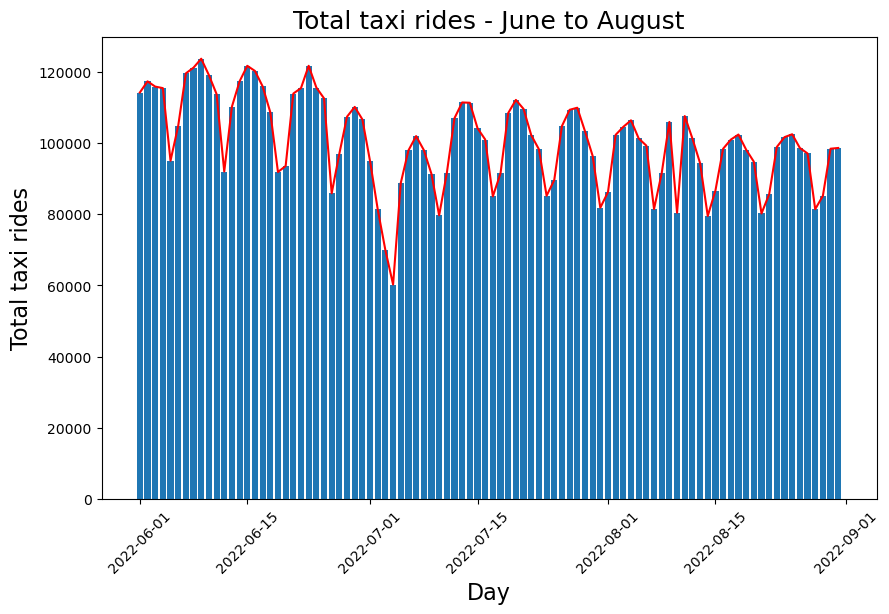

In [26]:
Tp_tips = yellow[['date', 'tip_amount']] #Get a subset of our dataset

Tp_tips = Tp_tips.groupby('date').count() #Obtain the number of rides for each day of our 3-month period

plt.figure(figsize=(10, 6)) #Set size of the plot

plt.bar(yellow['date'].unique(), Tp_tips['tip_amount']) #Produce a barplot of the total taxi rides per day...
plt.plot(yellow['date'].unique(), Tp_tips['tip_amount'], color = 'r') #...with an overlaid line showing the trend

plt.xlabel('Day', fontsize = 16) #Set x axis labels
plt.xticks(rotation=45) #Rotate x axis labels
plt.ylabel('Total taxi rides', fontsize = 16) #Set y xis labels

plt.title("Total taxi rides - June to August", fontsize = 18) #Set title

plt.show() #Show the plot

In the above plot we can see how Tuesdays, Wednesdays, Thursdays and Fridays are best for the taxi industry, since during these days the highest number of taxi rides are recorded. Contrarily, the weekends and Mondays attain the lowest number of rides out of each week.

Along the same lines we can observe monthly plots. In June, when most people are still in the city, there are more taxi rides recorded that in July and August, where some workers have holidays and decide to leave the city, or just do not need to take taxis to go to their working location. In this hypothesis, the number of taxi rides not taken by New Yorkers outpowers the number of taxis taken by visitors in the city, whose number might be constant throughout all the summer months.

Note that there is a particular date where the recorded taxi rides achieved a distinguished minimum. This date was the 4th of July, a bank holiday in New York city.

---
**Total daily tips over time - June to August**

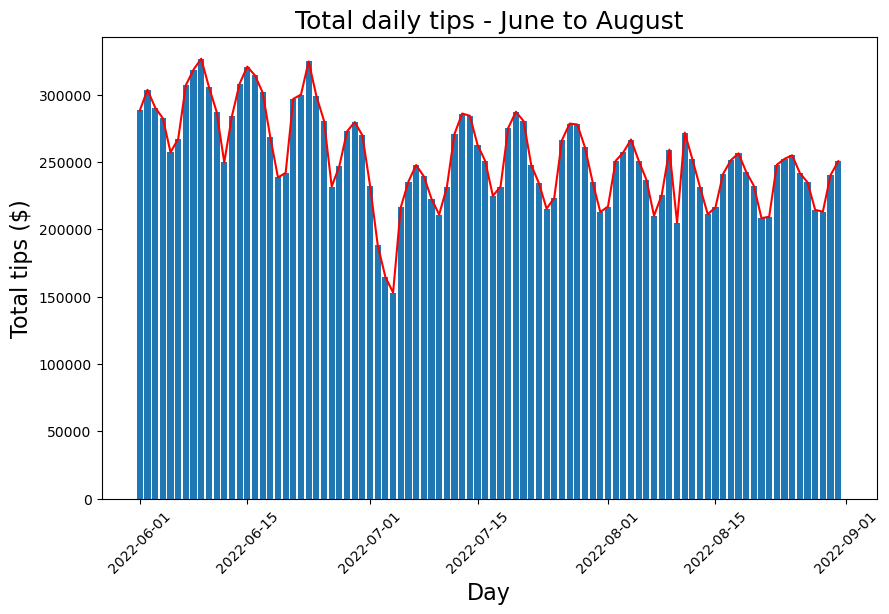

In [27]:
Tp_tips = yellow[['date','tip_amount']] #Get a subset of our dataset

Tp_tips = Tp_tips.groupby('date').sum() #Obtain total tips for each day of our 3-month period

plt.figure(figsize=(10, 6)) #Set size of the plot

plt.bar(yellow['date'].unique(), Tp_tips['tip_amount']) #Produce a barplot with the total tips each day...
plt.plot(yellow['date'].unique(), Tp_tips['tip_amount'], color = 'r') #...with an overlaid line showing the trend

plt.xlabel('Day', fontsize = 16) #Set x axis labels
plt.xticks(rotation=45) #Rotate x axis labels
plt.ylabel('Total tips ($)', fontsize = 16) #Set y xis labels

plt.title("Total daily tips - June to August", fontsize = 18) #Set title

plt.show() #Show the plot

As it can be seen in the above plot, there is a weekly trend in the total tips. In particular, we can see how Wednesdays and Thursdays gather the largest total tips for the taxi industry, while the weekends and Mondays lead to a lower tip collection. Furthermore, it can also be observed that there is a higher number of tips given in the month of June, with a reduction in July and a further decrease in August. These phenomena can be produced by either differences in the tipping behaviour for each day or, more probably, a difference in the number of total taxi rides taking each day. The second hypothesis agrees to what it is observed in the plot showing the total number of taxi rides over the summer months.

Lastly, note that we can see in the graph a day for which the total tips gathered were surprisingly low. In fact, this corresponds to the 4th of July. As this is a bank holiday in New York, the low total tips gathered can be explained simply by the low number of taxi rides taken that day, concurring with the plot showing total taxi rides.

---
**Total daily tips throughout the week**

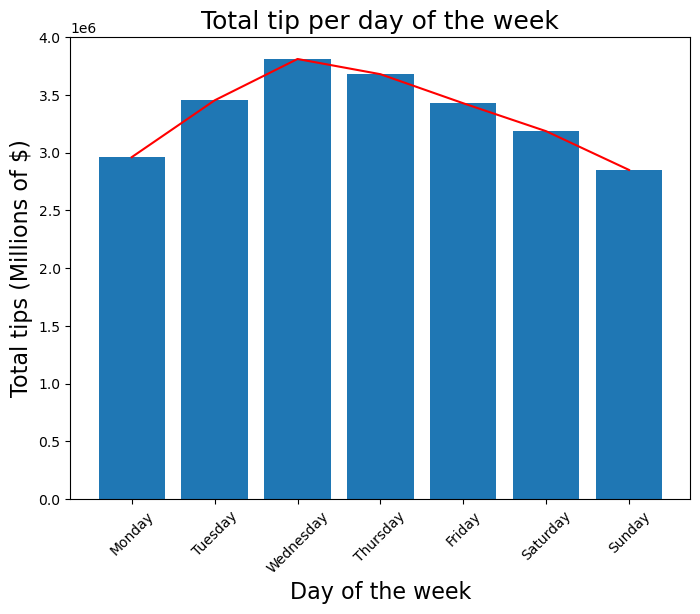

In [28]:
keys_week = np.arange(0,7) # set the keys of the dictionary
values_week = ['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # set the values of the dictionary
week_days_names = dict(zip(keys_week,values_week)) # set a dictionary of every day of the week

tip_lst = [yellow[yellow['day'] == d]['tip_amount'].sum() for d in values_week] # sum the tips of every day of the week and convert the data to list

plt.figure(figsize=(8,6)) # set the size of figure
plt.bar(values_week, tip_lst) # plot a bar of tips of every day of the week
plt.plot(values_week, tip_lst, color='r') #...with an overlaid line showing the trend

plt.xlabel('Day of the week', fontsize = 16) # set x-axis 
plt.xticks(rotation=45) #Rotate x axis labels
plt.ylabel('Total tips (Millions of $)', fontsize = 16) # set y-axis 
plt.title('Total tip per day of the week', fontsize = 18) #Set title

plt.show()

From the plot above, we can deduce that from June to August 2022, the total amount of tips is highest on Wednesday, followed by Thursday, while the total amount of tips on Monday and Sunday is the lowest. This seems to be clearly correlated with the total number of taxi rides each of these days.

---
**Average tip per day of the week**

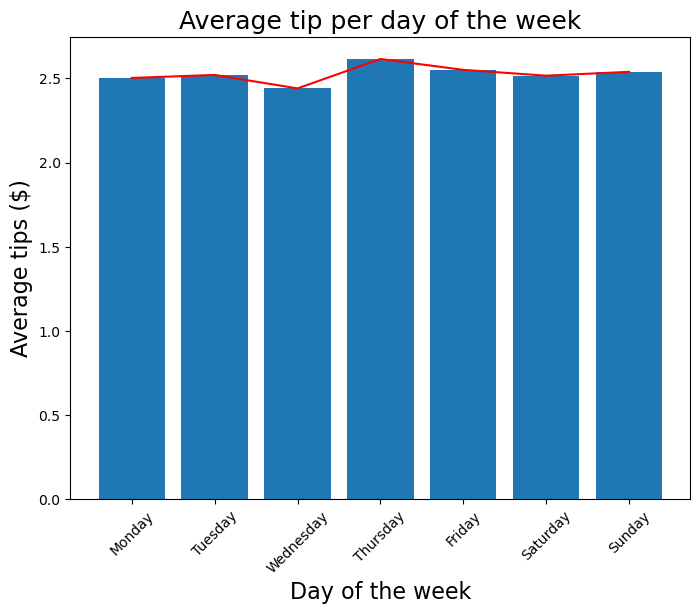

In [29]:
Tp_tips = yellow[['day','tip_amount']] #Get a subset of out dataset

Tp_tips = Tp_tips.groupby('day').mean() #Obtain the average tip per day of the week

plt.figure(figsize=(8, 6)) #Set plot size

plt.bar(values_week, Tp_tips['tip_amount']) #Produce a barplot...
plt.plot(values_week, Tp_tips['tip_amount'], color = 'r') #...with an overlaid line showing the trend

plt.xlabel('Day of the week', fontsize = 16) #Set x axis labels
plt.xticks(rotation=45) #Rotate x axis labels
plt.ylabel('Average tips ($)', fontsize = 16) #Set y axis labels
plt.title('Average tip per day of the week', fontsize = 18) #Set title

plt.show() #Show the plot

The average tips per ride for each day of the week is displayed in the above graph. The tips are higher, on average, on Thursdays, coinciding with the day what more taxis are taken and with the results of the correlation matrix. However, there is a really small difference with regards to the other days of the week.

---
**Percentage of rides which are tipped per day**

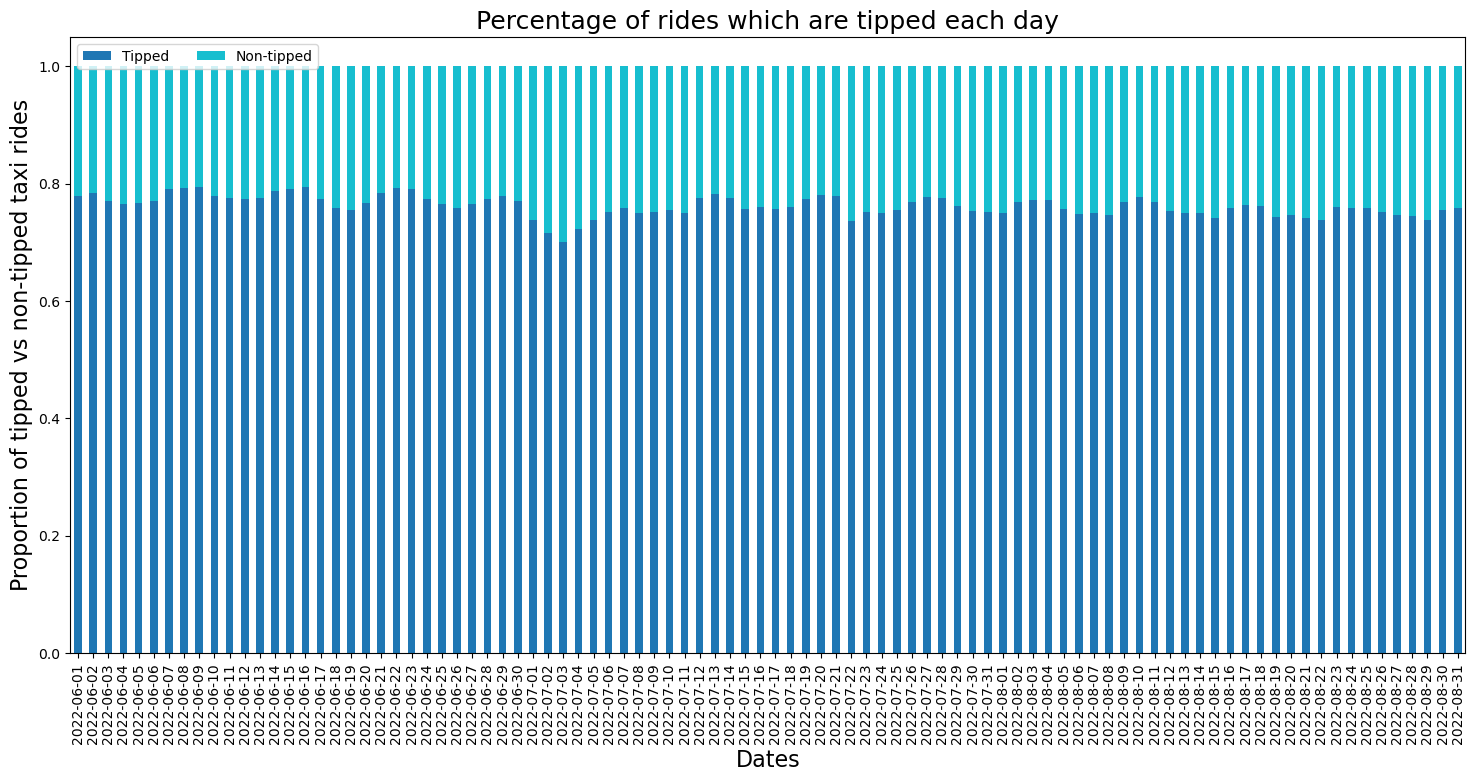

In [30]:
total_rides = yellow.groupby(['date']).count() #count the total number of ride for each day


#calculate the number of rides that are tipped and not tipped
num_Zero = yellow[yellow['tip_amount'] == 0].groupby(['date']).count()['tip_amount'] #number of rides that are not tipped
num_NonZero = yellow[yellow['tip_amount'] != 0].groupby(['date']).count()['tip_amount'] #number of rides that are tipped 

#calculate the percentage of the rides that are tipped
tip_percent = pd.DataFrame(num_NonZero/(num_NonZero+num_Zero)) # calculate the percentage of tipping
tip_percent.columns = tip_percent.columns.str.replace('tip_amount', 'num_nonzero%') #change the column name
tip_percent['num_zero%'] = 1 - tip_percent['num_nonzero%'] #calculate the percentage of non-tipping

#plotting a 100% stacked bar chart to show the percentage
tip_percent.plot(kind='bar', stacked=True, colormap='tab10', figsize=(18, 8))

plt.legend(['Tipped', 'Non-tipped'], loc="upper left", ncol=2) #set the legend
plt.xlabel("Dates", fontsize = 16) #name the x-label
plt.ylabel("Proportion of tipped vs non-tipped taxi rides", fontsize = 16) #name the y-label
plt.title("Percentage of rides which are tipped each day", fontsize = 18) #name the title

plt.show() #plot the graph

The percentage of the tipping did vary across time. In general, the willingness of tipping is relatively high, for about 78% in average. The plot also shows a cyclical behavior during each week, which is in accordance with the total tips and rides we calculated for each within a week. This indicates that during the middle of the week (Wednesday and Thursday primarily), not only the total volume of rides and thus total tipping amount will be higher, but also the tipping behavior will occur more frequently. 

Moreover, it is noticable that there is an anomaly on July 3rd, the day before Independence Day, a bank holiday. In fact, the frequency of the tipping dropped below the average level on this date. Around this bank holiday in New York, the frequency of the tipping became relatively low.

---
**Average tips against trip duration and Average total amount paid against trip duration**

Now, we plot the avergae tip and the average amount paid per taxi ride against the trip duration, in order to see how they follow an extremely similar trend.

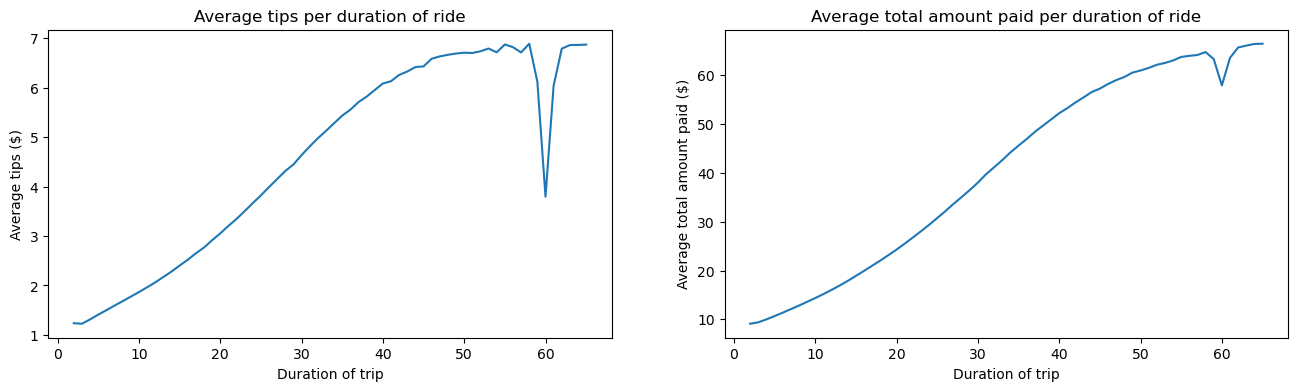

In [31]:
# Graph of the relationship between tips level and duration of trip
Td_tips = yellow[['duration_of_trip','tip_amount']] # Extract the data of 'duration_of_trip' and 'tip_amount'
Td_tips['duration_of_trip'] = round(Td_tips['duration_of_trip']) # Round off the duration of the trip
Td_tips = Td_tips.groupby('duration_of_trip').mean()  # Calclulatr the average tips in the duration of every minutes
x = []
for i in range(2,66): # The duration of trips range from 2 to 65 minutes
    x.append(i)

# Graph of the relationship between total amount and duration of trip
Td_total = yellow[['duration_of_trip','total_amount']] # Extract the data of 'duration_of_trip' and 'total_amount'
Td_total['duration_of_trip'] = round(Td_total['duration_of_trip']) # Round off the duration of the trip
Td_total = Td_total.groupby('duration_of_trip').mean() # Calclulatr the average total amount in the duration of every minutes


# Plot the graph together 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 4)) # create subplot

ax1.plot(x, Td_tips['tip_amount']) # Plot the graph between average tips and duration of trip
ax2.plot(x, Td_total['total_amount']) # Plot the graph between average total amount and duration of trip

#set the xlabel, ylabel and title for first subplot
ax1.set_xlabel('Duration of trip')
ax1.set_ylabel('Average tips ($)')
ax1.title.set_text('Average tips per duration of ride')

#set the xlabel, ylabel and title for second subplot
ax2.set_xlabel('Duration of trip')
ax2.set_ylabel('Average total amount paid ($)')
ax2.title.set_text('Average total amount paid per duration of ride')


As can be seen from the graph, at first the one-hour tip level increases with the duration of the trip, but then drops significantly at the one-hour mark. As the total amount of the fare also drops significantly at the one-hour mark, it is possible that the drop in tips given is related to the drop in the total amount of the trip, suggesting that people tend to tip some 'fixed' percentage of the total fee paid.

---
**Average tip for distance travelled**

Now, we analyse the relation in the trend of tipping behaviour in relation to the distance travelled. First, we will plot a histogram with the distribution of the distance of the taxi rides.

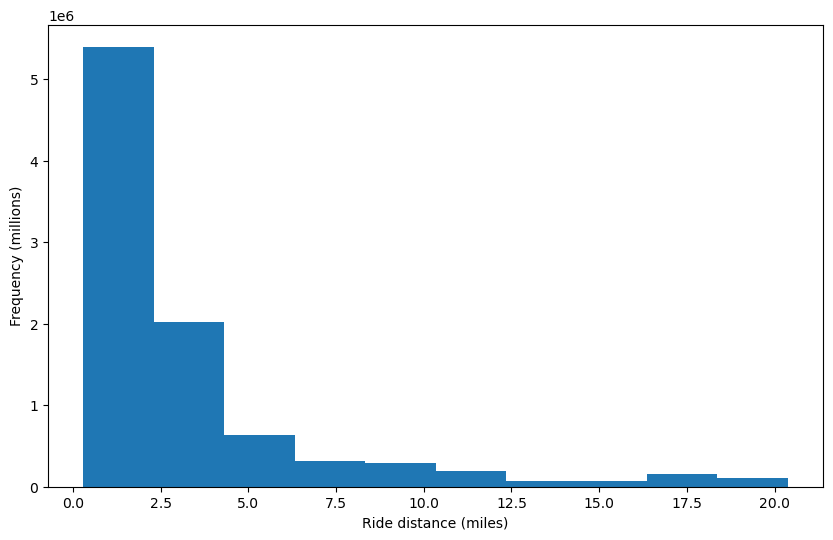

In [32]:
plt.figure(figsize= (10,6)) # set the size of figure
plt.hist(yellow['trip_distance']) # plot the histogram of the distance of all trips 
plt.xlabel('Ride distance (miles)') # set x-axis label
plt.ylabel('Frequency (millions)') # set x-axis

plt.show()

According to the plot above, we found that people are more inclined to take yellow taxis for short trips, and the most popular trip distance is  between 0 and 5 miles.

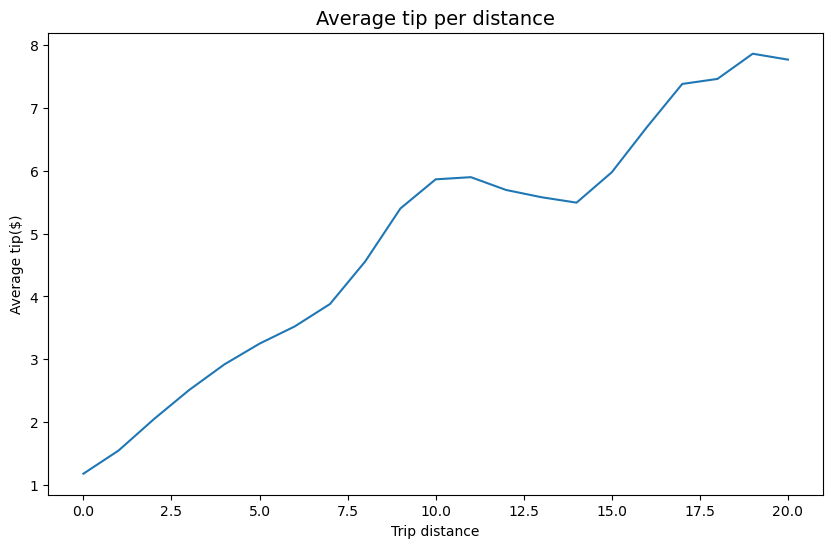

In [33]:
yellow['trip_distance_round'] = round(yellow['trip_distance']) # round the distance of every trip 
dt_tip = yellow[['trip_distance_round', 'tip_amount']] # set a dataframe of 'trip_distance_round' and 'tip_amount'

dt_tip1 = dt_tip.copy()
dt_tips = dt_tip.groupby('trip_distance_round', as_index=False).sum() # sum the tip amount of the same distance

t_lst = dt_tips['trip_distance_round'].tolist() # convert the distance after rounding to list

dt_tips['number'] = dt_tip1.groupby('trip_distance_round').count() # add a column of number of the same distance after rounding
dt_tips['avg'] = dt_tips['tip_amount'] / dt_tips['number'] # calculate the average tip of the same distance

plt.figure(figsize=(10,6)) # set the size of figure
plt.xlabel('Trip distance') # set x-axis
plt.ylabel('Average tip($)') # set y-axis
plt.title('Average tip per distance', fontsize = 14) #Set title
plt.plot(t_lst, dt_tips['avg'].tolist()) # plot the trip distance and average tips


plt.show() #show the plot

Further research on the relationship between tips and distance, they are positively correlated, in accordance to what was shwon in the correlation heatmap. Nevertheless, when the distance is between 10 and 14 miles, the tip does not follow the same trend, as it decreases with distance. In the histogram above we could observe a significant decrease in trips between 10 and 14 miles long.

---
**Evolution of tips thorughout the day**

Now, we analyse how the tipping behaviour of customers change throughout the day.

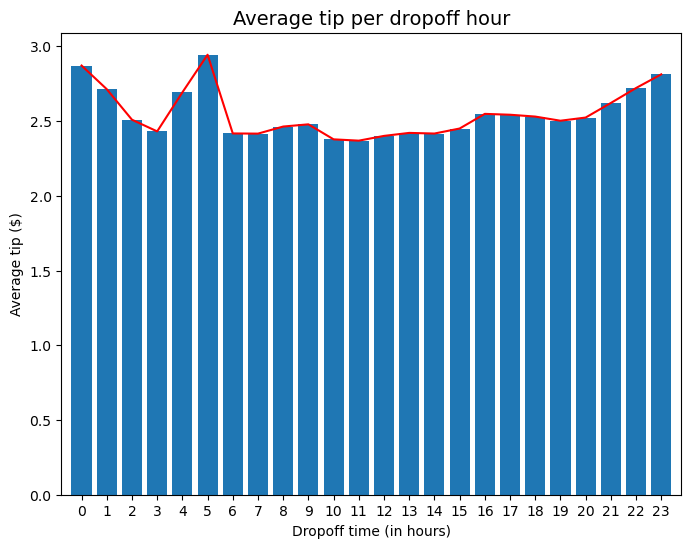

In [34]:
# Graph of tip levels at each moment(in hours) of the day on a daily average
Tp_tips = yellow[['tpep_dropoff_datetime','tip_amount']] # Extract the data of 'tpep_dropoff_datetime' and 'tip_amount'
Tp_tips['dropoff_hour'] = Tp_tips['tpep_dropoff_datetime'].dt.hour # Extract the 'Hour' of each dropoff_datetime
Tp_tips = Tp_tips[['dropoff_hour','tip_amount']] # Extract the data of 'dropoff_hour' and 'tip_amount'
Tp_tips1 = Tp_tips.copy() # Copy the data of Tp_tips
Tp_tips = Tp_tips.groupby('dropoff_hour').sum() # Calculate the total amount of tips for these three months at different moments in the day (in hours) and merge the data
Tp_tips['number']= Tp_tips1.groupby('dropoff_hour').count() # Calculate the number of trips for these three months at different moments in the day (in hours)
Tp_tips['average_tips_hour'] = Tp_tips['tip_amount']/Tp_tips['number'] #Calculate the average tips for these three months at different moments in the day (in hours)
x1 = list(range(24)) # The hour of the day varies from 0-23 hours

# Plot the graph of the change of tip levels with the change of the moments(in hours) of a day
plt.figure(figsize=(8, 6)) #Set plot size
plt.bar(x1, Tp_tips['average_tips_hour'])
plt.plot(x1, Tp_tips['average_tips_hour'], color = 'r')
plt.xlabel('Dropoff time (in hours)') # Name the x-axis
plt.ylabel('Average tip ($)') # Name the y-axis
plt.title('Average tip per dropoff hour', fontsize = 14) #Set title


ax = plt.gca() # Get the current Axes instance on the current figure matching the given keyword
ax.xaxis.set_major_locator(MultipleLocator(1)) # The x-axis is marked at intervals of 1
plt.xlim(-0.8,23.8) # set the length of x-axis
plt.show()


As can be seen from the graph, tipping remains at a relatively constant level of around $2.5 during the day from 06:00 to 20:00, where people usually take taxis to go to work or to attend certain events. From 20:00 until midnight, the  the tip level gradually increases. In addition, the tip level fluctuates considerably above the daytime level between 00:00 and 06:00, reaching a maximum at 05:00.

---
**Proportion of the tip corresponding to the total taxi fee, per trip duration**

Now, we produce a scatter plot to analyse what proportion of the total amount paid corresponds to tips, against the duratino of the taxi ride. 

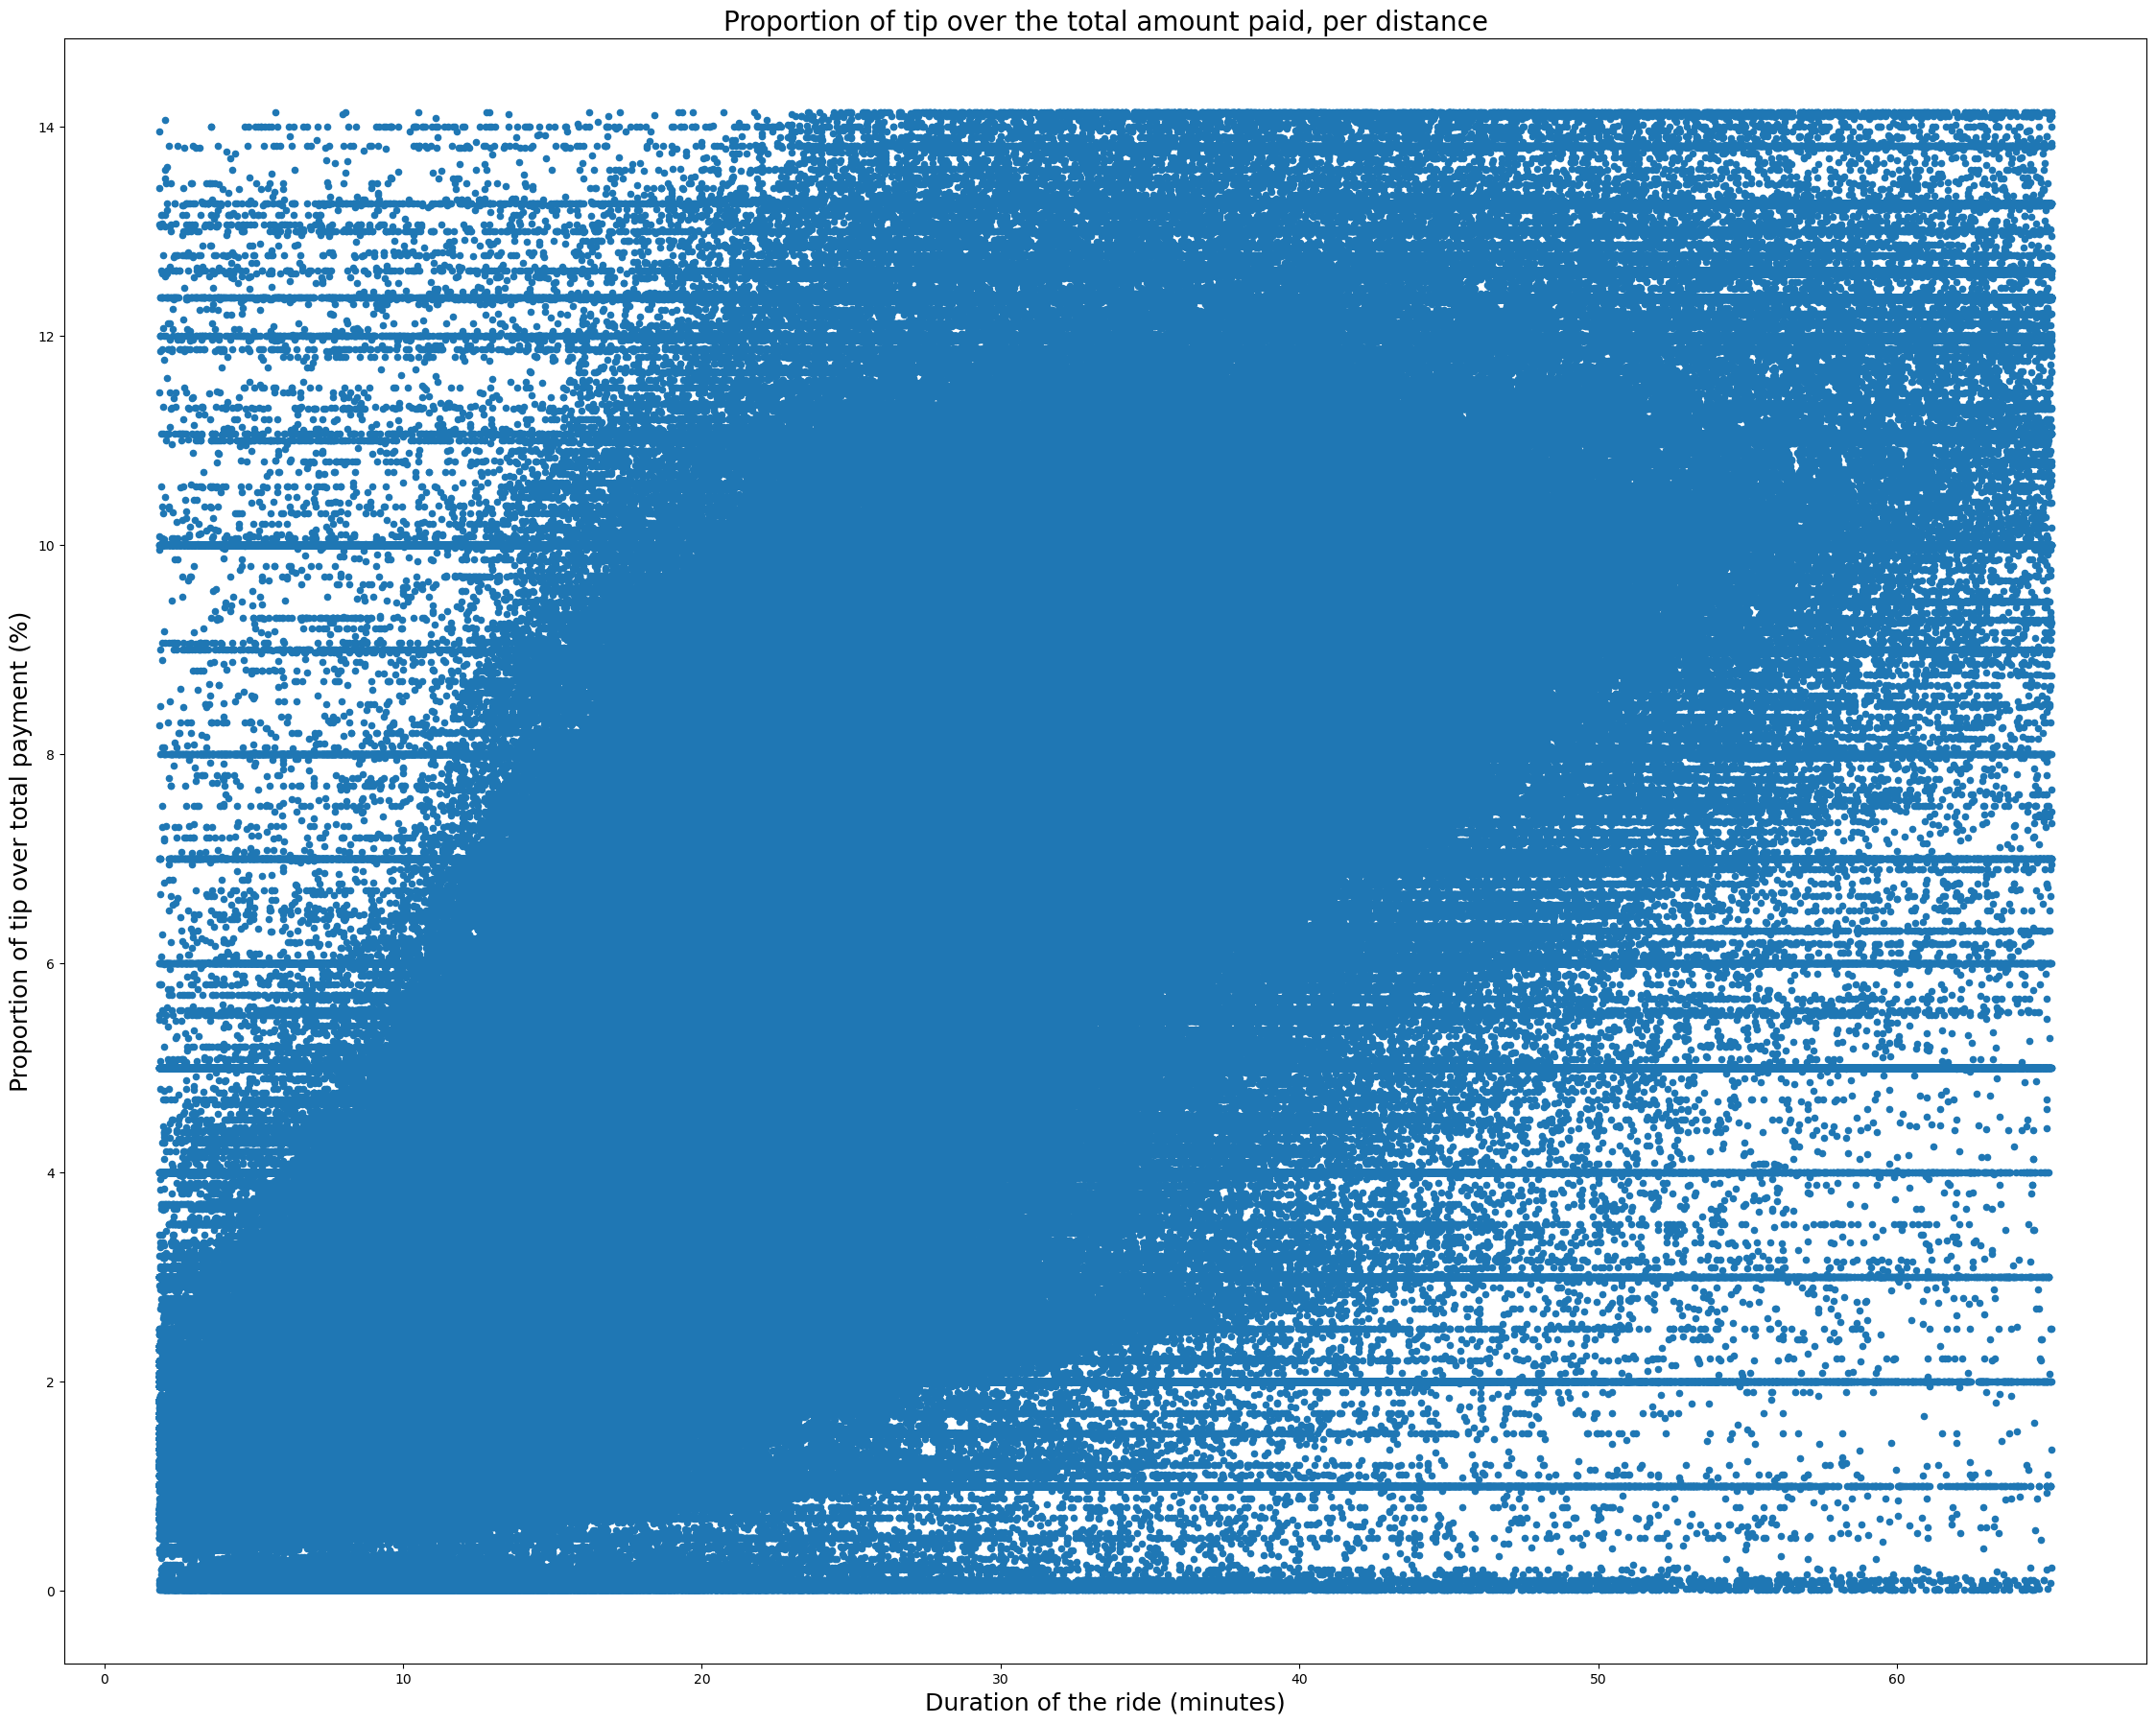

In [35]:
tip_df = pd.DataFrame() # define tip_df as dataframe
tip_df['tip'] = yellow.loc[(yellow['tip_amount'] > 0), 'tip_amount'] # get the data that have tips
tip_df['duration'] = yellow.loc[(yellow['tip_amount'] > 0), 'duration_of_trip'] #create duration of the trip in the new dataframe
tip_df = tip_df.sort_values(by=['duration']) #sort the data by duration

#plotting the proportion of the tip corresponding to the total taxi fee
tip_df.plot.scatter(x = 'duration', y = 'tip', figsize=(28, 22)) #scatter plot
plt.xlabel("Duration of the ride (minutes)", fontsize = 18) #set x label
plt.ylabel("Proportion of tip over total payment (%)", fontsize = 18) #set y label
plt.title("Proportion of tip over the total amount paid, per distance", fontsize = 20) #set title

plt.show()

The proportion of the tipping amount relative to the total taxi fee is concentrated in the range of 0% to 14% approximately (except some outliers). For shorter duration, the data is more concerntrated between 0% and 7%. For longer duration, the range moved to 7% and 14%. This indicates that with longer duration, people are more willingly to tip more. Thus, there is a clear relation between the duration of the ride and how much passengers are willing to tip. There is also a tendency to tip an exact percentage of the total fee, regardless of the duration of the ride.

---
**Precipitation**

In the following graph we analyse the effect of precipitation in the average tip

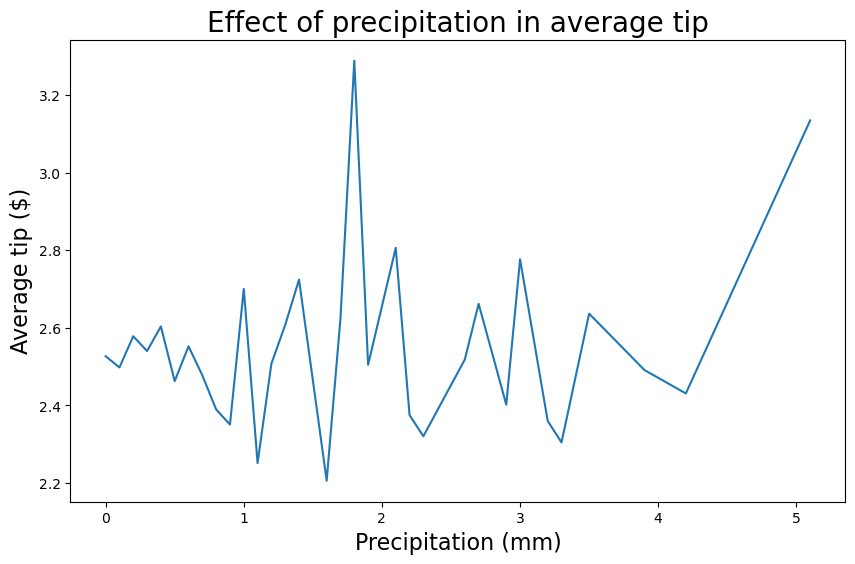

In [36]:
weather_tip = yellow[['tpep_pickup_datetime', 'tip_amount', 'precipitation']]  #set a dataframe including 'tpep_pickup_datetime', 'tip_amount', 'precipitation'
weather_tip1 = yellow[['tpep_pickup_datetime', 'precipitation']] #set a dataframe including 'tpep_pickup_datetime', 'precipitation'
weather_tip2 = weather_tip1.copy()

weather_tips = weather_tip.groupby('precipitation',as_index=False).sum() # sum the tips in the same precipitation which as_index=False
precipitation_lst = weather_tips['precipitation'].tolist() # convert precipitation column to list
weather_tips = weather_tip.groupby('precipitation').sum() # sum the tips in the same precipitation

weather_tips['number'] = weather_tip2.groupby('precipitation').count() # calculate the number of the same precipitation
weather_tips['avg'] = weather_tips['tip_amount']/weather_tips['number'] # calculate the average of tips of the same precipitation


plt.figure(figsize=(10,6)) # set the size of figure
plt.title('Effect of precipitation in average tip', fontsize = 20)
plt.xlabel('Precipitation (mm)', fontsize = 16)  # set x-axis
plt.ylabel('Average tip ($)', fontsize = 16) # set y-axis
plt.plot(precipitation_lst, weather_tips['avg']) # plot the precipitation and average weather
plt.show()

According to the plot above, we can see that there is no clear relation between precipitation and the average tip. When the precipitation is greater than 4mm, the tip is almost linearly related to the precipitation. That is to say, passengers generally believe that when there is strong precipitation, the driver derves a higher tip. However, with lower precipitation, there are subjective differences in people's tipping behaviour, resulting in no significant connection between precipitation and tip. Interestingly, when the precipitation is around 2mm, the tip increases significantly.

The low relation between these two parameters can be possibly explained by the lack of taxi rides during summer that happen while there is a storm. If the data used were from colder months (autumn or winter) another relation between the features might be observed.

---
 **S&P 500 stock market price and tips**
 
Lastly, we analyse the stock market data to see if there is any apparent relationship between the changes in the S&P 500 prices and the willingness of people to tip their taxi drivers.

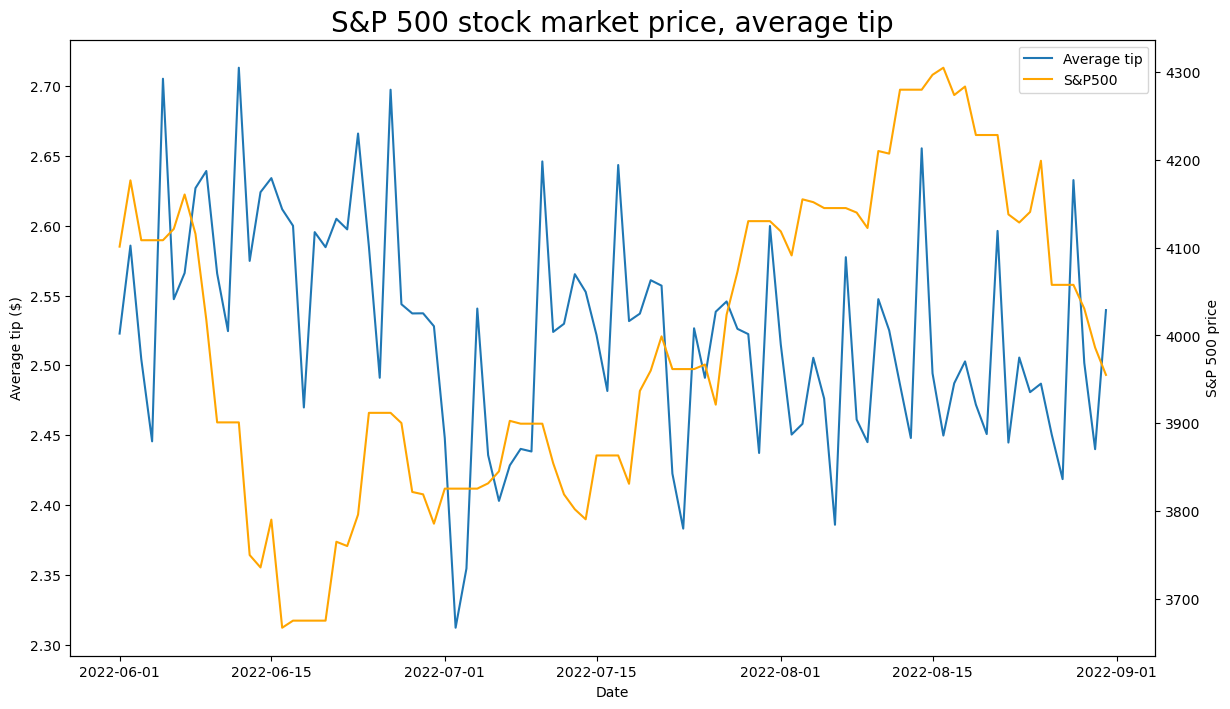

In [37]:
# with open('S&P500.csv') as fp: # open the file of S&P 500
#     df = pd.read_csv(fp)
df_SP = df['price'].tolist() # convert the S&P500 to list

dt_tip = yellow[['date', 'tip_amount']] # set a dataframe of 'date' and 'tip_amount'
dt_tip1 = dt_tip.copy() 
dt_tips = dt_tip.groupby('date', as_index=False).sum() # sum the tips of the same date
date_lst = dt_tips['date'].tolist() # convert the date to list

dt_tips = dt_tip.groupby('date').sum() # sum the tip everyday
dt_tips['number'] = dt_tip1.groupby('date').count() # add a column of the number of trip everyday
dt_tips['avg'] = dt_tips['tip_amount'] / dt_tips['number'] # add a column of the average tip everyday
tip_average = dt_tips['avg'].tolist() # convert the average tip to list

x = [i for i in date_lst] # set x-axis
y1 = [i for i in tip_average] # set y1-axis (average tip)
y2 = [i for i in df_SP] # set y2-axis (S&P500)


fig, ax1 = plt.subplots(figsize = (14,8)) # plot the average tip by day
ax1.plot(x, y1 ,label='Average tip')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average tip ($)')

ax2 = ax1.twinx() # plot the S&P500 by day
ax2.plot(x, y2, color='orange', label='S&P500')
ax2.set_ylabel('S&P 500 price')

handles1, labels1 = ax1.get_legend_handles_labels() # change the label position
handles2, labels2 = ax2.get_legend_handles_labels() # change the label position for the second subplot
plt.legend(handles1 + handles2, labels1 + labels2) #plot legend
plt.title("S&P 500 stock market price, average tip", fontsize = 20) #set title

plt.show()


From the plot above, we can see that the fluctuations of S&P 500 and the average tip are very consistent in certain intervals. Although there is no obvious linear relationship, it is enough to prove that macroeconomics can affect people's willingness to tip.

---

### Map


**Tips in pickup and dropoff locations**

Lastly, we analyse the taxi zones where the tips were more prominent.

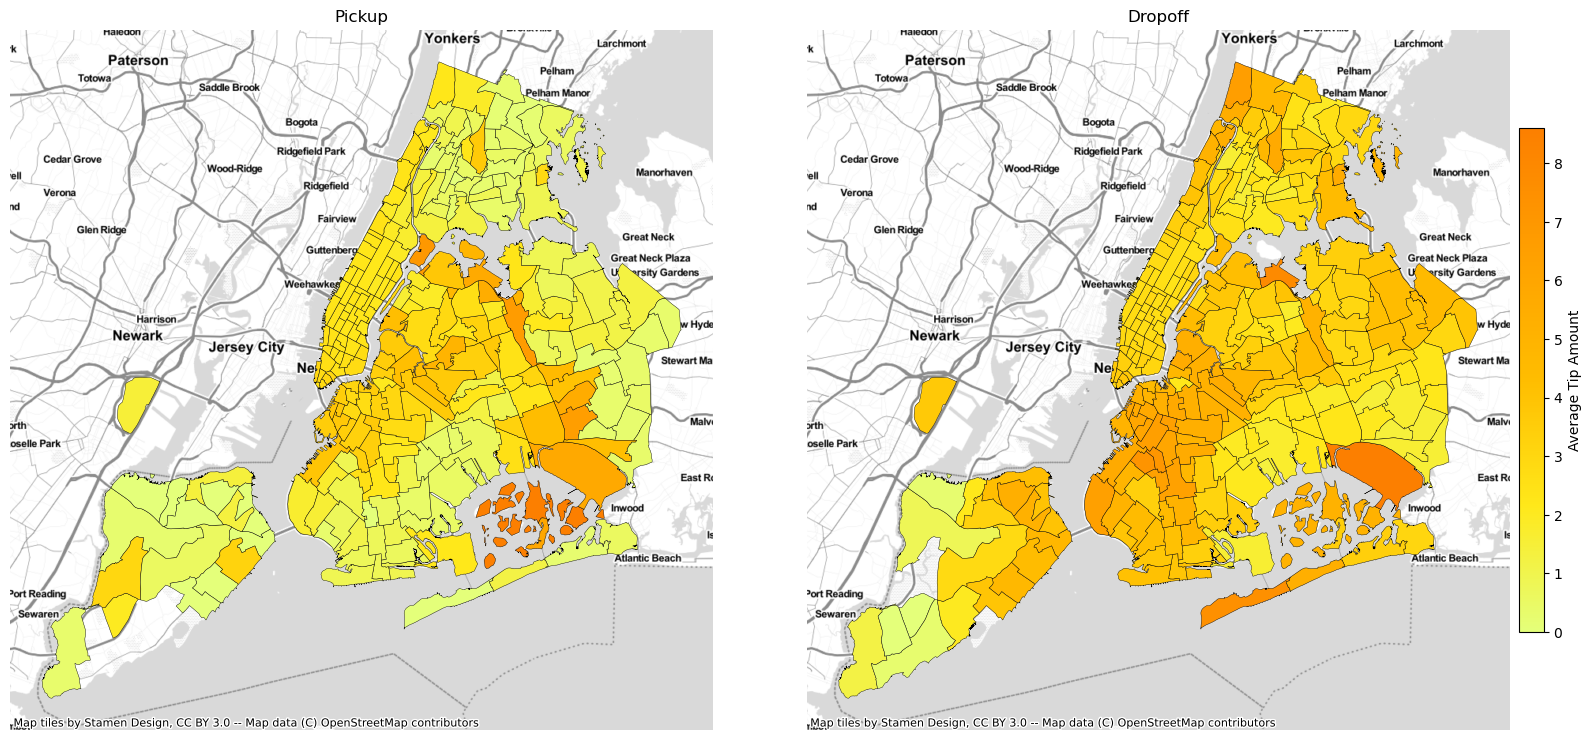

In [198]:
tz = gpd.read_file('taxi_zones') # Read the file of the data of taxi zone
tz['geometry'] = tz['geometry'].to_crs('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs') # Project geographic data information from the geographic coordinate system of the ellipsoid to planar coordinates

plt_yellow = yellow[['PULocationID', 'tip_amount']] # Extract the data of 'PULocationID', 'tip_amount'
dlt_yellow = yellow[['DOLocationID', 'tip_amount']] # Extract the data of 'DOLocationID', 'tip_amount'
p_zone = plt_yellow.groupby('PULocationID').mean() # Caculate the average tips in each pickup loacation
d_zone = dlt_yellow.groupby('DOLocationID').mean() # Caculate the average tips in each dropoff location

# Merge the geographic coordinate ID information of the plane into the original data table and drop the data information in the geographic coordinate system to build a new dataframe with geometry
p_zone = gpd.GeoDataFrame(pd.merge(p_zone, tz, left_on='PULocationID', right_on='LocationID')).drop('LocationID', axis=1) 
d_zone = gpd.GeoDataFrame(pd.merge(d_zone, tz, left_on='DOLocationID', right_on='LocationID')).drop('LocationID', axis=1) 

# Project the data to the coordinate system of New York City of which the epsg code is 3857
p_zone = p_zone.to_crs(epsg=3857)
d_zone = d_zone.to_crs(epsg=3857)

# Lay out subplots and set size
fig, taxi_map = plt.subplots(ncols=2, figsize=(20, 10))
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=1.0, wspace=0.1, hspace=0.1)

# Create a normalized colorbar
taxi_map[0] = p_zone.plot(column='tip_amount', linewidth=0.3, edgecolor='black', figsize=(10, 10), 
    cmap='Wistia', legend=False, ax=taxi_map[0]) # Set area border line parameters and block fill color of the left subplot
ctx.add_basemap(taxi_map[0], source = ctx.providers.Stamen.TonerLite) # Add a basemap to the left subplot

taxi_map[1] = d_zone.plot(column='tip_amount', linewidth=0.3, edgecolor='black', figsize=(10, 10), 
     cmap='Wistia', legend=False, ax=taxi_map[1]) # Set area border line parameters and block fill color of the right subplot
ctx.add_basemap(taxi_map[1], source = ctx.providers.Stamen.TonerLite) # Add a basemap to the right subplot

# Name each subplot
taxi_map[0].set_title('Pickup')
taxi_map[1].set_title('Dropoff')
# Turn the x-axis off
taxi_map[0].set_axis_off() 
taxi_map[1].set_axis_off()

# Draw the color bar
tips_col = taxi_map[0].collections[0] # Set the variable of the color bar
cb = fig.colorbar(tips_col, ax=taxi_map, shrink=0.72, orientation="vertical", pad=0.005) # Draw a color bar and set parameters of it
cb.ax.set_ylabel('Average Tip Amount') # Add a lable to the color bar
plt.show()

As it can be seen, the two plotted heatmaps give information on the average tipping behavior for each pickup and dropoff location. Darker / orange colours represent higher average tipping levels for a particular zone.

* For the pickup location, passenger picked up from Jamaica Bay Wildlife Refuge usually give the highest tips, more than any other areas. This might be explained by a lower volume of yellow taxis available in this region. The west part of the Queens area also noticed a higher tipping level. Compared to the west side, the east side of the Queens area shows a lower tipping level (indicated by lighter color). With regards to the other areas in New York City, there are no signficant difference as shown on the map.

* Focusing now on the dropoff locations, the John F. Kennedy International Airport is highlighted by a deeper color, showing that higher average tips were given to the driver when passengers are dropped off to the airport. Moreover, the average tips of the areas located in both side of the Verrazzano-Narrows Bridge are higher.

![separator1](https://i.imgur.com/ZUWYTii.png)

## Multiple Linear Regression

In the last step of this report, we perform a linear regression with multiple parameters, with the objective of explaining what features affect the tips given by passengers to their 'yellow' taxi drivers. We have evaluated data on trip duration, distance covered, total fee paid for the ride, when and where the rides happened andhow the stock market prices were evolving, among other things. From this information, we have decided to include the follwing variables in our final regression:

1. Total amount paid: There is a clear correlation between how expensive the taxi ride was and how much tip is given to the driver. Thus, we expect this parameter to be important when describing tipping behaviour.
2. Duration of the trip: There is an obvious correlation between how long the ride took and the tipping levels, and we believe this could be a determining factor when explaining the final tips given.
3. Ride distance: There is an evident relation between how far the drive was and how much tips passenger give at the end of the ride. Therefore, we have decided to include this factor in our regression.
4. Weekend(dummy variable): We have included a dummy variable accounting for whether the taxi ride tookk place in a weekend (1) or during a weekday (0). In previous models we included dummies for individual days, but these more complex models achieved no better accuracy than just having a variable controlling for weekend rides. Thus, we would only include this 'general' dummy variable, which simplifies our model in the number of parameters used.
5. Night (dummy variable): We are including a dummy variable controlling for whether the taxi ride took place between midnight and 6am (1) or not (0). As we have seen in the exploratory data analysis, there is some apparent relation connecting the time of the taxi ride and the final tip that is given to the driver.
6. Precipitation: There is a logical relation between precipitation and the number of taxi rides that are taken. In fact, when it rains, you would expect people to take taxis that they were not planning to. We want to analyse this behaviour against (possibly) unexpected rides, and how it affects the tips given. We are including this feature as a continous variable. Even though we also generated a dummy accounting for precipitation, it produced no major improvements in the preliminary models, and we believe that how much it rains is a relevant factor when deciding whether to take a taxi, and therefore also determines the tips given.
7. S&P 500 prices: From the exploratory data analysis, we were intrigued on the apparent relation between stock market prices and tipping levels. In order to delve into this, we are including the variable in our regression.

We expect all these variables but 'Precipitation' to have a positive effect in determining the tipping level of a taxi ride.

In [154]:
# linear Regression (with weekend dummy)

X = yellow[['total_amount','duration_of_trip','trip_distance', 'weekend', 'precipitation', 'night', 'SP500']] #specify
        #independent variables
Y = yellow['tip_amount'] #secify dependent variable

X = sm.add_constant(X) # add intercept, default option goes without intercept

model = sm.OLS(Y, X).fit() #fit the model, parameters determined by OLS
print_model = model.summary() #save the model summary in a variable
print(print_model) #print model summary

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                 2.514e+06
Date:                Tue, 06 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:25   Log-Likelihood:            -1.6495e+07
No. Observations:             9251612   AIC:                         3.299e+07
Df Residuals:                 9251604   BIC:                         3.299e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.5080      0.011  

Above we can observe the results of our regression.

Firstly, we note that all the variables in the model are significant to the 99% level. Moreover, the R-squared and adjusted R-squared statistics show that our model is able to predict approximately the 65% of the variation observed in the tipping levels.

Regarding our continuous variables, we only observe a positive effect towards the tipping level for the total amount paid for the ride. In particular, por each extra dollar from the drive, the expected tip should raise by 0.4 dollars approximately. On the other hand, an extra minute in the trip would reduce the tip by 0.1 dollars and an extra mile would reduce the tip by 0.76 dollars. Even if surprising, we note that these three factors are highly correlated between each other, and the magnitude for total payment is usually larger than distance or time spent (generally, you pay more dollars than minutes you have been in the taxi, or miles you have ridden). Thus, probably the coefficients of the last two variables are negative to 'control' the positive sign of 'total amount' and its magnitude, and the three coefficients should be interpretted together. 

Keeping our attention in the continuous variables, we see how both precipitation's and S&P 500's coefficients are negative. The fact that precipitation has an associated negative effect on tips surprised us, as we were expecting the contrary. An explanation might be that, if it rains, the traffic moves slower, and you pay more than what you were expecting, especially if you did not pla to take a taxi at first. This could lead to passengers not wanting to leave tips. Nevertheless, as we are working with summer months, precipitation does not happen frequently.  On the other hand, the effect of the stock market prices is negative but neglectable, and we can conclude that it does not yield any important effect in the tipping behaviour of people.

Moving now to the dummy variables, we see how the weekend binary variable has an associated positive effect in tips. If the taxi ride happens on a weekend, you would expect 0.08 dollars extra on the tip. Even if this is a small effect, it agrees with what was shown in the data exploration section. Lastly, night rides are predicted to yield 0.02 fewer dollars in tips, approximately. Again, this is shocking, since the higher tips were usually reached during the night, however the effect in the final tip is really small.

# Conclusion

During this report we have analysed the tipping behaviour of passengers when they take a yellow taxi during the months of June, July and August. We have studied the relation of features such as duration of the trip, distance covered and total fee to be paid against the tips received by the taxi drivers, while also investigating the differences in tipping behaviour across the week or the day.

Our final recommendations for drivers that were trying to maximise their tipping input during their working hours would be to take the rides that have some associated costs, especially if they do not take long or do not have to cover a lot of distance. If possible, focus on working on the weekends, when there might be a lower taxi offer and people tend to tip more. Aside from this, there is no need to work at night, since there is no apparent improvement in the final tips received. Lastly, if possible, work in the areas where the average tips are higher: Jamaica Bay Wildlife Refuge, Queens area, John F. Kennedy airport and the surroundings of Verrazzano-Narrows Bridge.